# Example GP emulator code 
### Applied to Thomas Kavoo's PPE experiment
##### Linnia Hawkins 7/19/2023

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import gpflow
from esem import gp_model
import tensorflow as tf
from gpflow.utilities import print_summary

from sklearn.preprocessing import StandardScaler, MinMaxScaler

2023-07-19 16:29:40.632375: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 16:29:40.802632: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-19 16:29:40.840630: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-19 16:29:41.590342: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
data = pd.read_csv("raw_data_gpp_params_values.csv",engine='python')

In [3]:
GPP = data['GPP'].values
gpp = GPP[GPP!=0] # drop ensemble members that crashed
gpp = gpp[0:355] # drop values that are nan in param file

std_scaler = StandardScaler()
gpp_scaled = std_scaler.fit_transform(gpp.reshape(-1, 1))

In [4]:
params = data.iloc[:,3:]
params = params[GPP!=0] # drop ensemble members that crashed
params = params.iloc[0:355,:] # drop values that are nan in param file

norm_scaler = MinMaxScaler()
ppe_params= norm_scaler.fit_transform(params[params.columns]) #LRH: these need to be normalized by column

In [5]:
num_params = np.shape(ppe_params)[1]
num_params

30

(array([ 4.,  5., 12., 23., 75., 93., 92., 33., 16.,  2.]),
 array([-3.62672602, -2.97132163, -2.31591723, -1.66051283, -1.00510844,
        -0.34970404,  0.30570035,  0.96110475,  1.61650915,  2.27191354,
         2.92731794]),
 <BarContainer object of 10 artists>)

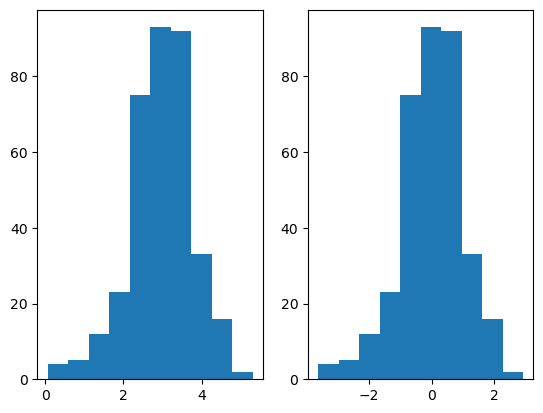

In [6]:
# check data
plt.subplot(1,2,1)
plt.hist(gpp)
plt.subplot(1,2,2)
plt.hist(gpp_scaled)

### Train emulator

In [7]:
# define kernel
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = np.tile(1,30))
#kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = 1)

kernel = kernel_linear + kernel_matern32 + kernel_RBF

2023-07-19 16:29:54.401041: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-19 16:29:54.401086: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc02): /proc/driver/nvidia/version does not exist
2023-07-19 16:29:54.405254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# split training and testing data
Y = gpp_scaled

ntest = 55
X_test, X_train = ppe_params[:ntest], ppe_params[ntest:]
y_test, y_train = Y[:ntest], Y[ntest:]

#ESEm
emulator = gp_model(np.array(X_train),np.array(y_train),kernel=kernel)
emulator.train()

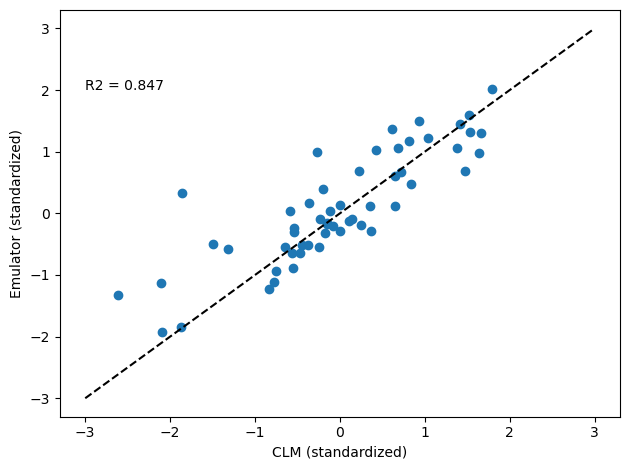

In [10]:
# plot validation
#plt.figure(figsize=[10,12])
#plt.rcParams.update({'font.size': 10})

y_pred, y_pred_var = emulator.predict(X_test)

r2 = np.corrcoef(y_test.flatten(),y_pred.flatten())

ax = plt.subplot(1,1,1)
ax.plot([-3,3],[-3,3],c='k',linestyle='--',label='1:1 line')
ax.scatter(y_test,y_pred)
ax.text(-3,2,'R2 = '+str(np.round(r2[0,1],3)),fontsize=10)
ax.set_xlabel('CLM (standardized)',fontsize = 10)
ax.set_ylabel('Emulator (standardized)',fontsize = 10)
plt.tight_layout()

### GPflow only

In [13]:
#GPflow
kernel = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = 1)

emulator = gpflow.models.GPR(data=(X_train, y_train), kernel=kernel, mean_function=None)
emulator.likelihood.variance.assign(.01)
emulator.kernel.lengthscales.assign(0.3)

print_summary(emulator)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    1    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    0.3  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │    0.01 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

In [14]:
# implements the L-BFGS-B algorithm
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(emulator.training_loss, emulator.trainable_variables, options=dict(maxiter=10000))
print_summary(emulator)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 6.09027 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 5.11742 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.07804 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

In [16]:
#validate
y_pred, y_var = emulator.predict_f(X_test)

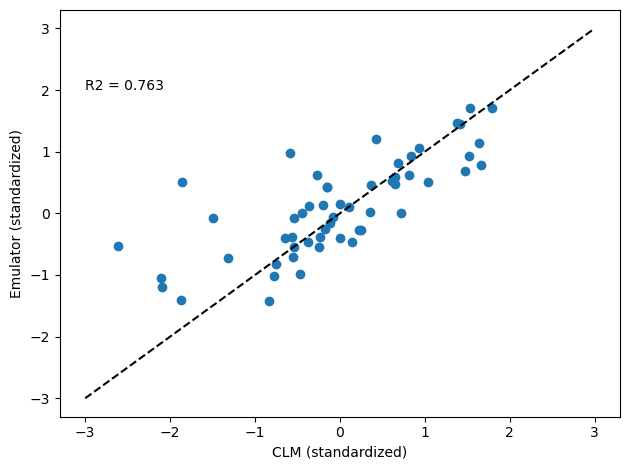

In [24]:
r2 = np.corrcoef(y_test.flatten(),np.array(y_pred).flatten())

ax = plt.subplot(1,1,1)
ax.plot([-3,3],[-3,3],c='k',linestyle='--',label='1:1 line')
ax.scatter(y_test,y_pred)
ax.text(-3,2,'R2 = '+str(np.round(r2[0,1],3)),fontsize=10)
ax.set_xlabel('CLM (standardized)',fontsize = 10)
ax.set_ylabel('Emulator (standardized)',fontsize = 10)
plt.tight_layout()